In [368]:
rm *.json TSLA.csv

# Stock data scraper

In [369]:
import urllib.request, json , time, os, difflib, itertools
import pandas as pd
from multiprocessing.dummy import Pool
from datetime import datetime
import http.client as httplib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import csv

# можно переделать сбор с yahoo через yfinance

In [370]:
def check_internet():
    conn = httplib.HTTPConnection("www.google.com", timeout=5)
    try:
        conn.request("HEAD", "/")
        conn.close()
        return True
    except:
        conn.close()
        return False

In [371]:
def stock_init():
    json_path = ""
    csv_path = ""
        
    ticker = "TSLA"
    
    csv_file = ticker + '.csv'

    period2 = str(round(datetime.now().timestamp()))
    period1 = str(round(int(period2) - 1 * 3600 * 24 * 365))
    print(period2 + " || " + str(datetime.now().strftime('%y/%m/%d')))
    print(period1 + " || " + str(datetime.utcfromtimestamp(int(period1)).strftime('%d/%m/%y')))

    interval = "1d"

    query_urls = "https://query1.finance.yahoo.com/v8/finance/chart/"+ticker+"?symbol="+ticker+"&period1="+period1+"&period2="+period2+"&interval="+interval+"&includePrePost=true&events=div%2Csplit"
    
    return ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls

In [372]:
def get_frame(parsed):
    Date=[]
    for i in parsed['chart']['result'][0]['timestamp']:
#         Date.append(datetime.utcfromtimestamp(int(i)).strftime('%d/%m/%y'))
        Date.append(datetime.utcfromtimestamp(int(i)).strftime('%d/%m/%y'))

        Low=parsed['chart']['result'][0]['indicators']['quote'][0]['low']
        Open=parsed['chart']['result'][0]['indicators']['quote'][0]['open']
        Volume=parsed['chart']['result'][0]['indicators']['quote'][0]['volume']
        High=parsed['chart']['result'][0]['indicators']['quote'][0]['high']
        Close=parsed['chart']['result'][0]['indicators']['quote'][0]['close']
        Adjusted_Close=parsed['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

        df=pd.DataFrame(list(zip(Date,Open,High,Low,Close, Adjusted_Close,Volume)),columns =['Date','Open','High','Low','Close','Adj Close','Volume'])
    
    return df

In [373]:
def get_historic_price(query_url,json_path,csv_path):
    
    stock_id=query_url.split("&period")[0].split("symbol=")[1]

    if os.path.exists(csv_path+stock_id+'.csv') and os.stat(csv_path+stock_id+'.csv').st_size != 0:
        print("<<<  Historical data of "+stock_id+" already exists")
        return
    
    while not check_internet():
        print("Could not connect, trying again in 5 seconds...")
        time.sleep(5)

    try:
        with urllib.request.urlopen(query_url) as url:
            parsed = json.loads(url.read().decode())
    
    except:
        print("|||  Historical data of "+stock_id+" doesn't exist")
        return
    
    else:
        if os.path.exists(json_path+stock_id+'.json') and os.stat(json_path+stock_id+'.json').st_size != 0:
            os.remove(json_path+stock_id+'.json')
        
        with open(json_path+stock_id+'.json', 'w') as outfile:
            json.dump(parsed, outfile, indent=4)
        
        try:
            df = get_frame(parsed)
            
            if os.path.exists(csv_path+stock_id+'.csv'):
                os.remove(csv_path+stock_id+'.csv')
            df.to_csv(csv_path+stock_id+'.csv', sep=',', index=None)
            
            print(">>>  Historical data of "+stock_id+" saved")
        
        except:
            print(">>>  Historical data of "+stock_id+" could not be saved")

In [374]:
def csv_draw(csv_file):

    frame = pd.read_csv(csv_file, index_col=0,parse_dates=True)
    frame.index.name = 'Date'
    
    mpf.plot(frame, type='candle', style = 'sas',  
             mav = (3,6,9),volume=True, figscale = 2)
   #           savefig = "TSLA_chart.png")
    
    

In [375]:
check_internet()

True

In [376]:
ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls = stock_init()

1671023849 || 22/12/14
1639487849 || 14/12/21


In [377]:
get_historic_price(query_urls, json_path, csv_path)

>>>  Historical data of TSLA saved


In [381]:
cp TSLA.csv TSLA3.csv

In [382]:
frame = pd.read_csv(ticker + '.csv', index_col=0,parse_dates=True)
frame.index.name = 'Date'
frame

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-14,315.000000,322.136658,310.000000,319.503326,319.503326,70806300
2021-12-15,317.736664,326.250000,309.416656,325.329987,325.329987,75169200
2021-12-16,331.500000,331.660004,307.283325,308.973328,308.973328,82771500
2021-12-17,304.923340,320.220001,303.013336,310.856659,310.856659,100437300
2021-12-20,303.566681,307.230011,297.796661,299.980011,299.980011,56480100
...,...,...,...,...,...,...
2022-07-12,175.029999,179.380005,172.220001,174.039993,174.039993,84213300
2022-08-12,172.199997,175.199997,169.059998,173.440002,173.440002,97624500
2022-09-12,173.839996,182.500000,173.360001,179.050003,179.050003,104746600


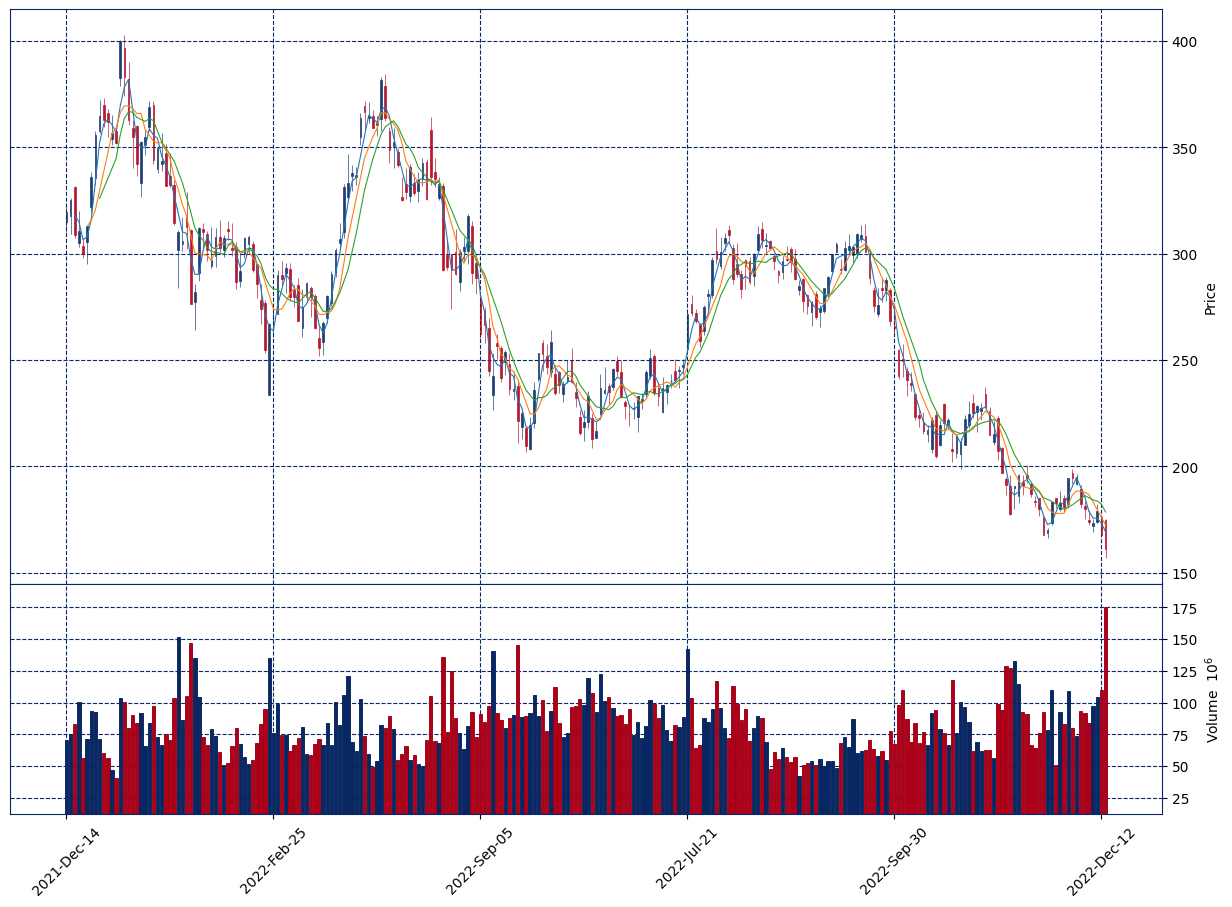

In [383]:
csv_draw(ticker + ".csv")

# News scraper

In [384]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.firefox.options import Options

In [385]:
options = Options()
options.headless = True
options.page_load_strategy = 'eager'
options.set_preference('javascript.enabled', False)
options.set_preference("app.update.auto", False)
options.set_preference("app.update.enabled", False)

ticker = "TSLA"
period = "d"

links = ["https://finviz.com"]
#         "https://www.ft.com/"]

opt_links = ["https://finviz.com/quote.ashx?t="+ticker+"&p="+period]

In [424]:
browser = webdriver.Firefox(options=options)
browser.get(opt_links[0])

news_container = browser.find_element(By.CLASS_NAME, 'fullview-news-outer')
news = []
dates = []

for element in news_container.find_elements(By.TAG_NAME, 'a'):
    news.append(element.get_attribute('href'))

for element in news_container.find_elements(By.TAG_NAME, 'td'):
    if element.get_attribute('width') == '130':
        dates.append(element.text)

browser.quit()

In [427]:
len(dates)
len(news)

100

In [451]:
dates[0:12]

['Dec-14-22 04:52AM',
 '04:30AM',
 '01:41AM',
 '12:39AM',
 'Dec-13-22 10:11PM',
 '07:04PM',
 '05:43PM',
 '05:00PM',
 '04:54PM',
 '04:53PM',
 '04:47PM',
 '04:30PM']

In [387]:
unique_sites = set()
for site in news: 
    buff = site.split('.')
    unique_sites.add(buff[1])
    
print(unique_sites)

{'barrons', 'thestreet', 'wsj', 'investopedia', 'investors', 'fool', 'marketwatch', 'yahoo'}


In [453]:
# print(str(len(news)) + ' || ' + str(len(dates)))

curr_date = ''
new_dates = []
curr_month = '12'

# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June',
#           'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


for date in dates[0:12]:
    
    if int(ord(date[0])) > int(ord('9')):
        d, t = date.split(' ')
        month, day, year = d.split('-')

    month = curr_month
    new_dates.append(day + '/' + month + '/' + year)
    
#     if int(ord(date[0])) > int(ord('9')):
#         curr_date, curr_time = date.split(' ')
# #         print(curr_time)
#         _, d, y = curr_date.split('-')
#         curr_date = d + '/' + curr_month + '/' + y
        
# #     if 'AM' in curr_time:
# #         curr_time = curr_time[0:5]
# #     elif 'PM' in curr_time:

# #         ss = int(curr_time[0:1])
# #         ss += int(12)
# #         curr_time = str(ss) + curr_time[2:5]
            
#     else:
# #         if 'AM' in curr_time:
# #             curr_time = curr_time[0:5]
# #         elif 'PM' in curr_time:

# #             ss = int(curr_time[0:1])
# #             ss += int(12)
# #             curr_time = str(ss) + curr_time[2:5]
        
# #         new_dates.append(curr_date + ' ' + curr_time)
#         new_dates.append(curr_date)
     

# new_dates

In [454]:
new_dates

['14/12/22',
 '14/12/22',
 '14/12/22',
 '14/12/22',
 '13/12/22',
 '13/12/22',
 '13/12/22',
 '13/12/22',
 '13/12/22',
 '13/12/22',
 '13/12/22',
 '13/12/22']

In [410]:
articles = []
art = ""

for site in news[:12]:
    browser = webdriver.Firefox(options=options)
    browser.get(site)
    
    for paragraph in browser.find_elements(By.TAG_NAME, 'p'):
        art += paragraph.text

    articles.append(art)
    art = ""
    

    browser.quit()
    print("done")

done
done
done
done
done
done
done
done
done
done
done
done


In [413]:
import csv

Date, Close= [],[]

with open('TSLA.csv', 'r') as f:
    reader = csv.reader(f)
    
    for row in reader:
        Date.append(row[0])
        Close.append(row[4])
        

news_data = []
for i in range(0, len(articles)):
    news_data.append(new_dates[i] + ' ||   ' + articles[i])

In [414]:
news_data

['14/12/22 ||   Stock futures were up slightly Wednesday with investors expecting the Federal Reserve to boost interest rates by 50 basis points, a step down from the last four consecutive rate hikes of 0.75 a percentage point.These stocks could make moves Wednesday:Already a member? Sign In',
 '14/12/22 ||   (Bloomberg) --Most Read from BloombergApple to Allow Outside App Stores in Overhaul Spurred by EU LawsMusk Loses World’s Richest Title to Arnault With Tesla UnwindingElon Musk Is Ruining Trump’s Presidential CampaignUS Core Inflation Slows, Giving Fed Some Breathing Room on RatesTesla Stock Has Never Been This Cheap — And It Could Still Drop FurtherElon Musk’s prediction that Tesla would have an “epic” end of year looks more off base by the day.The ebullient outlook the CEO offered during the carmaker’s last earnings call has given way to price and production cuts in China. In the US, Tesla is offering consumers something previously unthinkable: a $3,750 incentive to take delivery

In [416]:
print(str(len(Date)) + ' ' + str(len(Close)))
Date[252]
len(news_data)

253 253


12

In [ ]:
articles_col = []
for i in range (len(Date)-1, 1):
    
        

In [409]:
print(Date[-1] + ' || ' + news_data[4])

13/12/22 || 13/12/22 ||   Tesla stock is down again, and investors once more are pointing fingers at Twitter. Fixing Twitter might not be enough to fix shares of the electric-vehicle giant, though. Technical stock market analysts see other factors at play.Tesla stock (ticker: TSLA) opened higher Tuesday, along with the rest of the market following slower-than-expected U.S. inflation data for November. The stock traded at $175.05 early in the day, up more than 4%.Already a member? Sign In


# Prediction model TRY

In [264]:
# ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls = stock_init()

In [265]:
# rm *.json TSLA.csv

In [266]:
# get_historic_price(query_urls, json_path, csv_path)

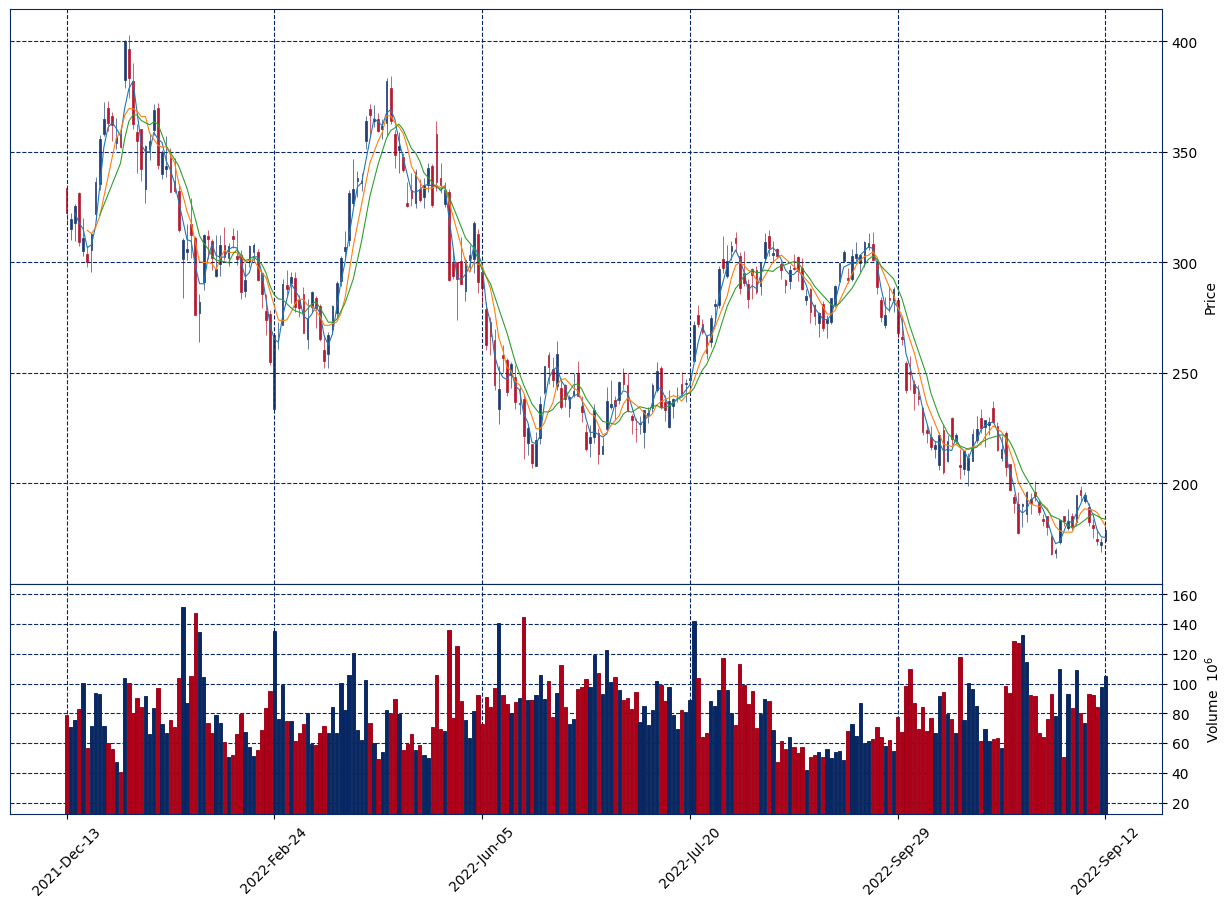

In [86]:
csv_draw(ticker + ".csv")

In [87]:
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score

In [88]:
NUM_DAYS = 10000
INTERVAL = interval
symbol = ticker

INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [89]:
df = pd.read_csv(ticker + '3.csv')
df.head()
# df.shape

,Date,Open,High,Low,Close,Adj Close,Volume
0,13/12/21,333.696655,335.000000,317.140015,322.136658,322.136658,78595500
1,14/12/21,315.000000,322.136658,310.000000,319.503326,319.503326,70806300
2,15/12/21,317.736664,326.250000,309.416656,325.329987,325.329987,75169200
3,16/12/21,331.500000,331.660004,307.283325,308.973328,308.973328,82771500
4,17/12/21,304.923340,320.220001,303.013336,310.856659,310.856659,100437300


In [90]:
data = df

/tmp/ipykernel_8819/1781492077.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  return df.ewm(alpha=alpha).mean()


<AxesSubplot:>

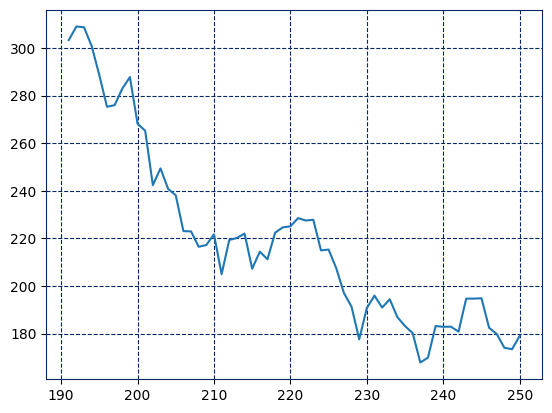

In [91]:
def _exponential_smooth(data, alpha):
    
    return df.ewm(alpha=alpha).mean()

df = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['Close'].plot()

In [92]:
def _get_indicator_data(data):

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(df)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])
    del (data['Adj Close'])
    
    data = data.dropna(axis=1, how='all')
    
    return data

data = _get_indicator_data(data)
# print(data.columns)

In [93]:
data.shape[0]

251

In [94]:
train_len = 6
test_len = 3

def get_trains(data, train_len):
    y_train = []
    x_train = []
    y_test = []
    x_test = []
    curr_state = 0
    
    while curr_state < data.shape[0]:
        
        df = data.iloc[curr_state:curr_state+train_len]
        targets = df['Close']
        del (df['Close'])
        features = df
        
        x_train, x_test, y_train, y_test = train_test_split(features, targets,
                                                           test_size=0.3)
        
        del x_train['Date']
#         del y_train['Date']

        curr_state += train_len 
    return x_train, x_test, y_train, y_test

In [95]:
X_train, X_test, y_train, y_test = get_trains(data, train_len)

In [96]:
live_pred_data = data.iloc[-16:-11]

def _produce_prediction(data, window):
    
    prediction = (data.shift(-window)['Close'] >= data['Close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['Close'])
del (data['Date'])
data = data.dropna()
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
231,30.717245,-14.128749,-12.850246,23.165299,-3.449824e+08,12.678460,-33.743681,42.009909,-13.174257,-3.713191e+08,-148.242313,-0.190520,1.106753,0.893685,0.780757,0.850258,0.890515,0.969606,1.118323,0.0
232,30.047493,-14.084292,-13.097055,20.371601,-3.159115e+08,12.445832,-35.593786,41.725342,-14.474757,-4.731334e+08,-122.086701,-0.244176,1.144798,0.873802,0.764378,0.834988,0.875425,0.953546,0.916579,0.0
233,31.879794,-13.751138,-13.227871,23.571852,-3.313770e+08,12.195412,-34.167831,41.442483,-14.767466,-3.781574e+08,-89.529582,-0.287101,1.165063,0.855377,0.781701,0.855992,0.897838,0.975610,0.921545,0.0
234,29.801874,-13.674065,-13.317110,15.661587,-3.646238e+08,11.919730,-30.197739,35.361544,-16.773910,-4.546679e+08,-96.113875,-0.369598,1.219711,0.803321,0.755260,0.829647,0.871147,0.947772,0.710816,0.0
235,27.992592,-13.771523,-13.407993,8.377819,-3.830855e+08,11.488622,-31.460208,35.778440,-18.611405,-5.232650e+08,-104.039546,-0.375560,1.252141,0.785111,0.743935,0.819972,0.862080,0.939918,0.724798,0.0


In [97]:
y_train

246    182.449997
248    174.039993
250    179.050003
Name: Close, dtype: float64

In [98]:
def _train_random_forest(X_train, y_train, X_test, y_test):
    
    rf = RandomForestClassifier()
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    rf_gs.fit(X_train, y_train)
    rf_best = rf_gs.best_estimator_
        
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best
    
# rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

In [99]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    params_knn = {'n_neighbors': np.arange(1, 25)}
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    knn_gs.fit(X_train, y_train)
    knn_best = knn_gs.best_estimator_
    
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best
    
    
# knn_model = _train_KNN(X_train, y_train, X_test, y_test)

In [100]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    estimators=[('knn', knn_model), ('rf', rf_model)]
    ensemble = VotingClassifier(estimators, voting='hard')
    ensemble.fit(X_train, y_train)
    
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble
    
# ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

In [101]:
df = data

def cross_Validation(data):
    
    num_train = 10
    len_train = 40
    
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)
        
        print('rf prediction is ', rf_prediction)
        print('knn prediction is ', knn_prediction)
        print('ensemble prediction is ', ensemble_prediction)
        print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
        
        
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
    
cross_Validation(data)

10 50


/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.67      0.86      0.75         7
         1.0       0.67      0.40      0.50         5

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12

[[6 1]
 [3 2]]


/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74         7
         1.0       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[7 0]
 [5 0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
0.6666666666666666 0.5833333333333334 0.5833333

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.1

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.08      0.15        12

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12

[[ 0  0]
 [11  1]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.0 0.08333333333333333 0.0
30 70
{'n_estimators': 150

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/p

{'n_neighbors': 11}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.50      0.71      0.59         7

    accuracy                           0.42        12
   macro avg       0.25      0.36      0.29        12
weighted avg       0.29      0.42      0.34        12

[[0 5]
 [2 5]]
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59         5
         1.0       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[5 0]
 [7 0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
0.4166666666666667 0.4166666666666667 0.416666

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 226, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklear

{'n_neighbors': 11}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      12.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0 12]
 [ 0  0]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0 0.0 1.0
50 90
{'n_estimators': 140}
              precision    recall  f1-score   support

         0.0       1.00 

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[11  1]
 [ 0  0]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

[[11  1]
 [ 0  0]]
rf prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.08333333333333333 0.9166666666666666 

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 226, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklear

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       1.00      0.45      0.62        11
         1.0       0.14      1.00      0.25         1

    accuracy                           0.50        12
   macro avg       0.57      0.73      0.44        12
weighted avg       0.93      0.50      0.59        12

[[5 6]
 [0 1]]
0.5
              precision    recall  f1-score   support

         0.0       1.00      0.45      0.62        11
         1.0       0.14      1.00      0.25         1

    accuracy                           0.50        12
   macro avg       0.57      0.73      0.44        12
weighted avg       0.93      0.50      0.59        12

[[5 6]
 [0 1]]
rf prediction is  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0.16666666666666666 0.5 0.5
70 110
{'n_estimators': 110}
     

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
0.75
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
0.75 0.75 0.75
80 120
{'n_estimators': 130}
              pre

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/p

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.8333333333333334 0.8333333333333334 0

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/p

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
0.25
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40         3
         1.0       0.00      0.00      0.00         9

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[3 0]
 [9 0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
0.25 0.25 0.25
100 140
{'n_estimators': 110}
              pr

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 226, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklear

{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.10      1.00      0.18         1
         1.0       1.00      0.18      0.31        11

    accuracy                           0.25        12
   macro avg       0.55      0.59      0.24        12
weighted avg       0.92      0.25      0.30        12

[[1 0]
 [9 2]]
0.25
              precision    recall  f1-score   support

         0.0       0.10      1.00      0.18         1
         1.0       1.00      0.18      0.31        11

    accuracy                           0.25        12
   macro avg       0.55      0.59      0.24        12
weighted avg       0.92      0.25      0.30        12

[[1 0]
 [9 2]]
rf prediction is  [1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.]
knn prediction is  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.6666666666666666 0.25 0.25
110 150
{'n_estimators': 110}
  

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 226, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklear

{'n_neighbors': 4}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0 0.0 0.0
120 160
{'n_estimators': 110}
            

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.42      1.00      0.59         5

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

[[0 7]
 [0 5]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
0.4166666666666667 0.4166666666666667 0.4166666

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/p

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
0.16666666666666666 0.8333333333333334 

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 226, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklear

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.67      0.18      0.29        11

    accuracy                           0.17        12
   macro avg       0.33      0.09      0.14        12
weighted avg       0.61      0.17      0.26        12

[[0 1]
 [9 2]]
0.16666666666666666
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.67      0.18      0.29        11

    accuracy                           0.17        12
   macro avg       0.33      0.09      0.14        12
weighted avg       0.61      0.17      0.26        12

[[0 1]
 [9 2]]
rf prediction is  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
0.4166666666666667 0.16666666666666666 0.16666

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 226, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklear

{'n_neighbors': 15}
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94         9
         1.0       0.75      1.00      0.86         3

    accuracy                           0.92        12
   macro avg       0.88      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12

[[8 1]
 [0 3]]
0.75
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84         9
         1.0       0.50      0.33      0.40         3

    accuracy                           0.75        12
   macro avg       0.65      0.61      0.62        12
weighted avg       0.72      0.75      0.73        12

[[8 1]
 [2 1]]
rf prediction is  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.08333333333333333 0.9166666666666666 0.75
160 200
{'n_esti

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/

{'n_neighbors': 13}
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[10  2]
 [ 0  0]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[10  2]
 [ 0  0]]
rf prediction is  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.3333333333333333 0.8333333333333334 

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 226, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklear

{'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         8
         1.0       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.17      0.50      0.25        12
weighted avg       0.11      0.33      0.17        12

[[0 8]
 [0 4]]
0.5
              precision    recall  f1-score   support

         0.0       1.00      0.25      0.40         8
         1.0       0.40      1.00      0.57         4

    accuracy                           0.50        12
   macro avg       0.70      0.62      0.49        12
weighted avg       0.80      0.50      0.46        12

[[2 6]
 [0 4]]
rf prediction is  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0.]
0.5 0.3333333333333333 0.5
180 220
{'n_estimators': 110}
     

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 226, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklear

{'n_neighbors': 8}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0 1.0 1.0
190 230
{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00  

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shuller03/.local/lib/p

{'n_neighbors': 6}
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
0.75
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86         9
         1.0       0.00      0.00      0.00         3

    accuracy                           0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12

[[9 0]
 [3 0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
0.75 0.75 0.75
200 240
RF Accuracy = 0.5
KNN Accuracy = 0.517

/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 226, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklear

# Predicting model

In [102]:
# rm *.json TSLA.csv

In [116]:
ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls = stock_init()

1670851628 || 22/12/12
1639315628 || 12/12/21


In [117]:
rm *.json TSLA.csv

In [118]:
get_historic_price(query_urls, json_path, csv_path)

>>>  Historical data of TSLA saved


In [119]:
def stock_data_gathering(ticker, query_url, json_path,
                        csv_path, csv_file):
    check_internet()
    get_historic_price(query_url,json_path,csv_path)
#     csv_draw(csv_file)


stock_data_gathering(ticker, query_urls, json_path,
                        csv_path, csv_file)

<<<  Historical data of TSLA already exists


In [122]:
import tensorflow as tf

In [123]:
df = pd.read_csv(ticker + '.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,13/12/21,333.696655,335.000000,317.140015,322.136658,322.136658,78595500
1,14/12/21,315.000000,322.136658,310.000000,319.503326,319.503326,70806300
2,15/12/21,317.736664,326.250000,309.416656,325.329987,325.329987,75169200
3,16/12/21,331.500000,331.660004,307.283325,308.973328,308.973328,82771500
4,17/12/21,304.923340,320.220001,303.013336,310.856659,310.856659,100437300


In [124]:
TIME = range(0, df.shape[0])
SERIES = df['Close']
SPLIT_TIME = 200
WINDOW_SIZE = 20
BATCH_SIZE = 32
SAMPLE_BUFFER = 170

In [125]:
def train_val_split(time, series, time_step=SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SAMPLE_BUFFER):

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [127]:
_, series_train, _, _ = train_val_split(TIME, SERIES, time_step = SPLIT_TIME)
dataset = windowed_dataset(series_train)
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [131]:
def create_uncompiled_model():
  
    model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
  ]) 

    return model

In [132]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mae') < 0.03):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

early_stopping = EarlyStopping()

In [138]:
def create_model():
#     tf.random.set_seed(51)
  
    model = create_uncompiled_model()
  
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])  
    return model
  
model = create_model()

history = model.fit(dataset, epochs=10, callbacks=[early_stopping])

Epoch 1/10
6/6 [==============================] - 16s 1s/step - loss: 281.0763 - mae: 281.5763
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 276.0035 - mae: 276.5035
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 272.8865 - mae: 273.3865
Epoch 4/10
6/6 [==============================] - 8s 1s/step - loss: 271.1676 - mae: 271.6676
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 270.0651 - mae: 270.5651
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 269.1329 - mae: 269.6329
Epoch 7/10
6/6 [==============================] - 8s 1s/step - loss: 268.2233 - mae: 268.7233
Epoch 8/10
6/6 [==============================] - 7s 1s/step - loss: 267.3313 - mae: 267.8313
Epoch 9/10
6/6 [==============================] - 7s 1s/step - loss: 266.4471 - mae: 266.9471
Epoch 10/10
6/6 [==============================] - 7s 1s/step - loss: 265.5752 - mae: 266.0752


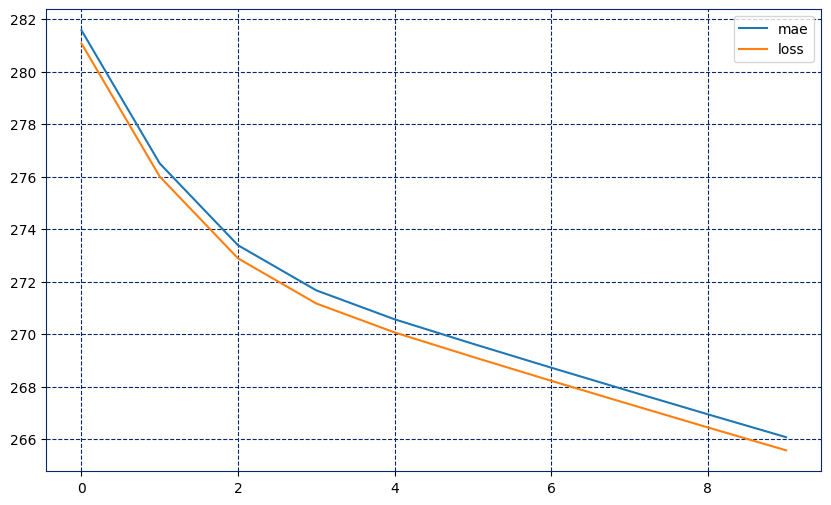

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [140]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

def model_forecast(model, series, window_size):

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

<AxesSubplot:>

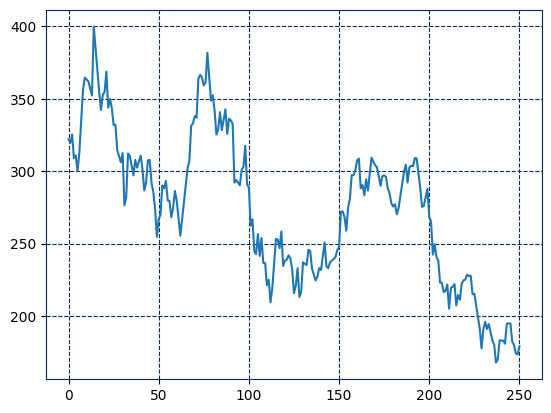

In [141]:
df['Close'].plot()

8/8 [==============================] - 4s 230ms/step


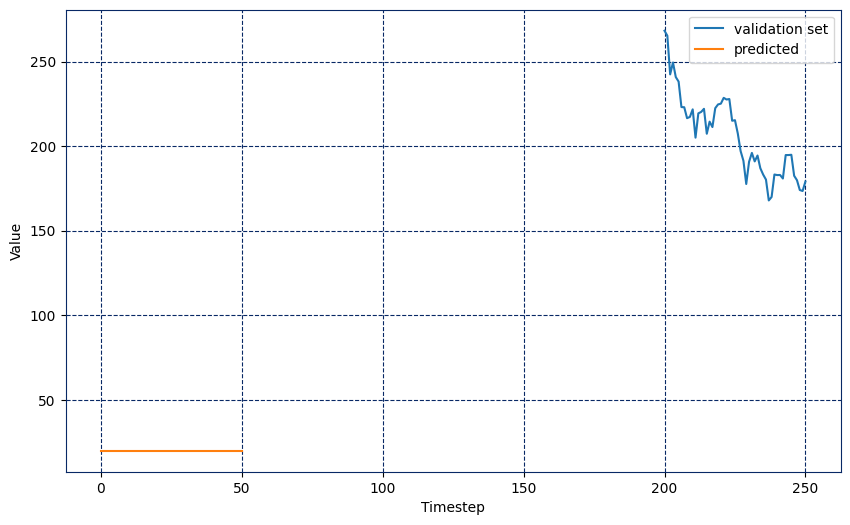

In [142]:
all_forecast = model_forecast(model, SERIES, WINDOW_SIZE).squeeze()
val_forecast = all_forecast[SPLIT_TIME - WINDOW_SIZE:-1]

plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

# LSTM training model

In [145]:
import numpy as np
from matplotlib import pyplot
import csv

from keras.layers import Dense, LSTM, Input, Dropout, Embedding, Bidirectional
from keras.utils import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

In [146]:
dataset = []
maxStrokeLen = 0

with open("stock_data.csv") as f:
    reader = csv.reader(f)
    for row in reader:
            dataset.append(row[0].strip())
            
for i in dataset:
    if i:
        if len(i) > maxStrokeLen:
            maxStrokeLen = len(i)
        
maxStrokesCount = len(dataset) - 1
    
print(maxStrokeLen)
print(maxStrokesCount)

154
5791


In [147]:
maxStrokeLen = 200
maxStrokesCount = 6000
maxWordLen = 12

positiveCount = 3685
negativeCount = 2106

tokenizer = Tokenizer(num_words=maxStrokesCount, lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(dataset)

dist = list(tokenizer.word_counts.items())


data = tokenizer.texts_to_sequences(dataset)
data_pad = pad_sequences(data, maxlen = maxWordLen)

X = data_pad
Y = np.array([[1,0]]*positiveCount + [[0,1]]*negativeCount)
print(X.shape, Y.shape)

(5792, 12) (5791, 2)


In [148]:
indeces = np.random.choice(X.shape[0]-1, size=X.shape[0]-1, replace=False)
X = X[indeces]
Y = Y[indeces]

In [149]:
model = Sequential()
model.add(Embedding(maxStrokesCount, 128, input_length = maxWordLen))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 128)           768000    
                                                                 
 lstm_10 (LSTM)              (None, 12, 128)           131584    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 949,122
Trainable params: 949,122
Non-trainable params: 0
_________________________________________________________________


In [150]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

In [151]:
history = model.fit(X, Y, batch_size=32, epochs=15)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

Epoch 1/15
181/181 [==============================] - 5s 14ms/step - loss: 0.6474 - accuracy: 0.6391
Epoch 2/15
181/181 [==============================] - 2s 14ms/step - loss: 0.5328 - accuracy: 0.7550
Epoch 3/15
181/181 [==============================] - 2s 14ms/step - loss: 0.4273 - accuracy: 0.8028
Epoch 4/15
181/181 [==============================] - 2s 14ms/step - loss: 0.3559 - accuracy: 0.8461
Epoch 5/15
181/181 [==============================] - 2s 14ms/step - loss: 0.3034 - accuracy: 0.8696
Epoch 6/15
181/181 [==============================] - 2s 13ms/step - loss: 0.2622 - accuracy: 0.8883
Epoch 7/15
181/181 [==============================] - 2s 14ms/step - loss: 0.2280 - accuracy: 0.9088
Epoch 8/15
181/181 [==============================] - 2s 14ms/step - loss: 0.1985 - accuracy: 0.9194
Epoch 9/15
181/181 [==============================] - 2s 14ms/step - loss: 0.1849 - accuracy: 0.9225
Epoch 10/15
181/181 [==============================] - 2s 14ms/step - loss: 0.1636 - accura

In [152]:
def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [153]:
t = "The oil brent is growing up! Economists predicts plus 5 precent to the cost".lower()
data = tokenizer.texts_to_sequences([t])
data_pad = pad_sequences(data, maxlen=maxWordLen)
print( sequence_to_text(data[0]) )

res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')

t1 = "Monday's relative weakness. NYX WIN TIE TAP ICE INT BMC AON C CHK BIIB  ".lower()
data = tokenizer.texts_to_sequences([t1])
data_pad = pad_sequences(data, maxlen=maxWordLen)
print( sequence_to_text(data[0]) )

res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')

t2 = "URALS brend is going higher and higher! Economysts forecasts a 10 precent growh in a week".lower()
data = tokenizer.texts_to_sequences([t2])
data_pad = pad_sequences(data, maxlen=maxWordLen)
print( sequence_to_text(data[0]) )

res = model.predict(data_pad)
print(res, np.argmax(res), sep='\n')

['the', 'oil', 'is', 'growing', 'up', 'economists', 'predicts', 'plus', '5', 'to', 'the', 'cost']
1/1 [==============================] - 1s 500ms/step
[[2.3995393e-05 9.9997604e-01]]
1
["monday's", 'relative', 'weakness', 'nyx', 'win', 'tie', 'tap', 'ice', 'int', 'bmc', 'aon', 'c', 'chk', 'biib']
1/1 [==============================] - 0s 17ms/step
[[9.9980181e-01 1.9815889e-04]]
0
['is', 'going', 'higher', 'and', 'higher', 'forecasts', 'a', '10', 'in', 'a', 'week']
1/1 [==============================] - 0s 17ms/step
[[0.00153194 0.998468  ]]
1
